In this tutorial, we use LTT to create prediction sets such that
precision score is controlled. The LTT method is implemented in MAPIE,
we will test it on a toy two-dimensional dataset.

Throughout this tutorial, we will answer the following questions:

-  How to select $\lambda$ such that my precision score is controlled ?

-  Why we can't select all $\lambda$ such that the risk is below  $\alpha$ level?


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB

from mapie.multi_label_classification import MapieMultiLabelClassifier

%matplotlib inline

# 1. Contruction of the dataset

We use a two-dimensional toy dataset with three possible labels. The idea is to create a triangle where the observations on the edges have only one label, those on the vertices have two labels (those of the two edges) and the center have all the labels

In [2]:
centers = [(0, 10), (-5, 0), (5, 0), (0, 5), (0, 0), (-4, 5), (5, 5)]
covs = [
    np.eye(2)**2, np.eye(2)**2, np.eye(2)**2, np.diag([5, 5]), np.diag([3, 1]),
    np.array([
        [4, 3],
        [3, 4]
    ]),
    np.array([
        [3, -2],
        [-2, 3]
    ]),
    
]

x_min, x_max, y_min, y_max, step = -15, 15, -5, 15, 0.1
n_samples = 800
X = np.vstack([
    np.random.multivariate_normal(center, cov, n_samples)
    for center, cov in zip(centers, covs)
])
classes = [[1, 0, 1], [1, 1, 0], [0, 1, 1], [1, 1, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1]]
y = np.vstack([np.full((n_samples, 3), i) for i in classes])

X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25
)

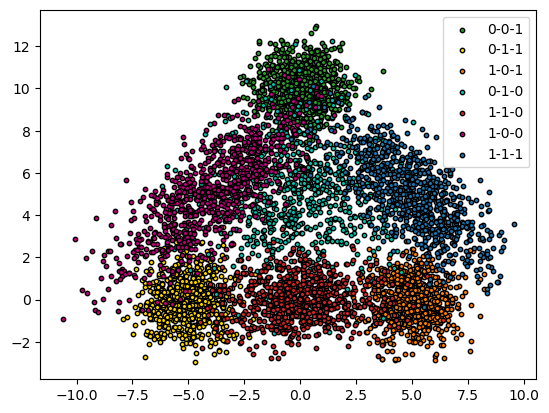

In [3]:
colors = {
    (0, 0, 1): {"color": "#1f77b4", "label": "0-0-1"},
    (0, 1, 1): {"color": "#ff7f0e", "label": "0-1-1"},
    (1, 0, 1): {"color": "#2ca02c", "label": "1-0-1"},
    (0, 1, 0): {"color": "#d62728", "label": "0-1-0"},
    (1, 1, 0): {"color": "#ffd700", "label": "1-1-0"},
    (1, 0, 0): {"color": "#c20078", "label": "1-0-0"},
    (1, 1, 1): {"color": "#06C2AC", "label": "1-1-1"}
}

for i in range(7):
    plt.scatter(
        X[n_samples * i:n_samples * (i + 1), 0],
        X[n_samples * i:n_samples * (i + 1), 1],
        color=colors[tuple(y[n_samples * i])]["color"],
        marker='o',
        s=10,
        edgecolor='k'
    )
plt.legend([c["label"] for c in colors.values()])

#  2 Fitting MapieMultilabelClassifier with Learn Then Test

In this part, we will use learn then test to control precision score. At the opposite of the 2 previous method, LTT can handle non-monotonous loss and it uses multiple hypothesis to control risk. This is why the output of this procedure isn't reduce to one value of $\lambda$.

- LTT:  $\mathbb{P}(R(\mathcal{T}_{\lambda}) \leq \alpha ) \geq 1 - \delta$, where $R(\mathcal{T}_{\lambda})$ is the risk we want to control for each $\lambda$ that satisfy FWER control and $\alpha$ is the desired risk.

Notice that the procedure will diligently examine each $\lambda$ such that the risk remains below level $\alpha$, meaning not every $\lambda$ will be considered. This means that a for a $\lambda$ such that risk is below $\alpha$ doesn't necessarly pass the FWER control! This is what we are going to explore.

In [4]:
clf = MultiOutputClassifier(GaussianNB()).fit(X_train, y_train)

In [5]:
mapie_clf =  MapieMultiLabelClassifier(estimator=clf, method='ltt', metric_control='precision')
mapie_clf.fit(X_cal, y_cal)


MapieMultiLabelClassifier(estimator=MultiOutputClassifier(estimator=GaussianNB()),
                          method='ltt', metric_control='precision')

In [6]:
alpha = 0.1
_, y_ps = mapie_clf.predict(X_test, alpha = alpha, delta = 0.1)


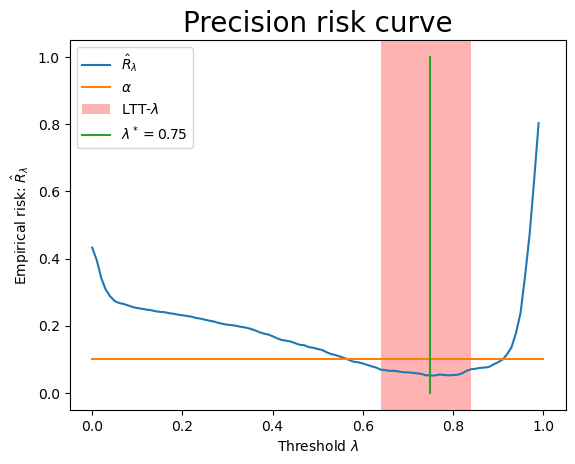

In [7]:
valid_index = mapie_clf.valid_index[0]  # valid_index is a list of list

lambdas = mapie_clf.lambdas[valid_index]

mini = lambdas[np.argmin(lambdas)]
maxi = lambdas[np.argmax(lambdas)]

r_hat = mapie_clf.r_hat
idx_max = np.argmin(r_hat[valid_index])

plt.plot(mapie_clf.lambdas, r_hat, label=r"$\hat{R}_\lambda$")
plt.plot([0, 1], [alpha, alpha], label=r"$\alpha$")
plt.axvspan(mini, maxi, facecolor='red', alpha=0.3, label=r"LTT-$\lambda$")
plt.plot(
    [lambdas[idx_max], lambdas[idx_max]], [0, 1],
    label=r"$\lambda^* =" + f"{lambdas[idx_max]}$"
)
plt.xlabel(r"Threshold $\lambda$")
plt.ylabel(r"Empirical risk: $\hat{R}_\lambda$")
plt.title("Precision risk curve", fontsize=20)
plt.legend()  
